## Семинар 2 "Распознавание рукописных цифр"

ФИО: Смирнов Егор Геннадьевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

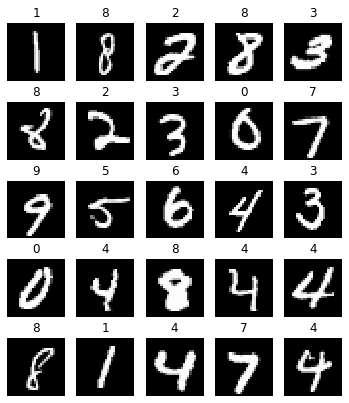

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [7]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

In [8]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

Сигмоида явно не лучший вариант..

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [57]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.082	Accuracy: 0.990/0.976

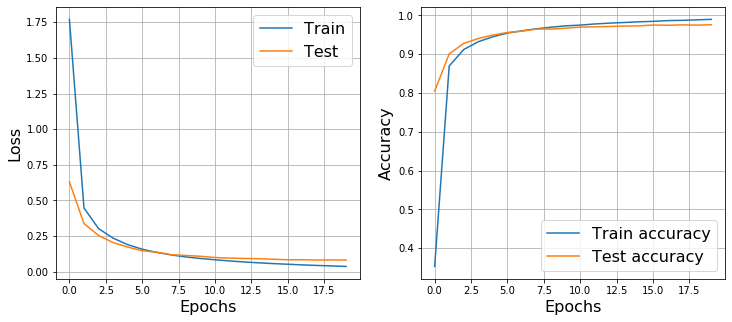

In [176]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.047/0.080	Accuracy: 0.987/0.975

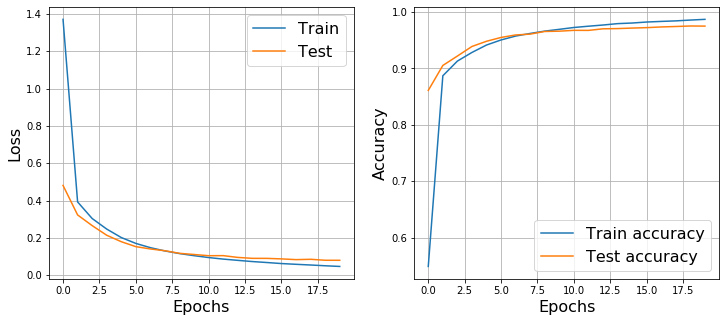

In [177]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

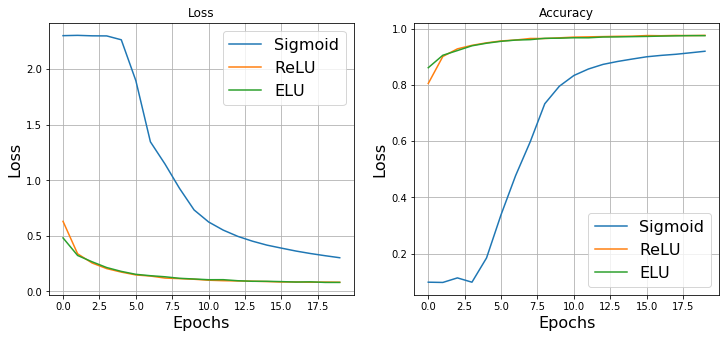

In [178]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [9]:
class Tanh:
    '''
    Tanh(x) = 2 / (1 + np.exp(-2 * x)) - 1
    '''
    
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        self.tan = 2./(1 + np.exp(-2. * self.X)) - 1.
        return self.tan
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydX = 1 - self.tan ** 2
        return dLdy * dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.029/0.077	Accuracy: 0.994/0.977

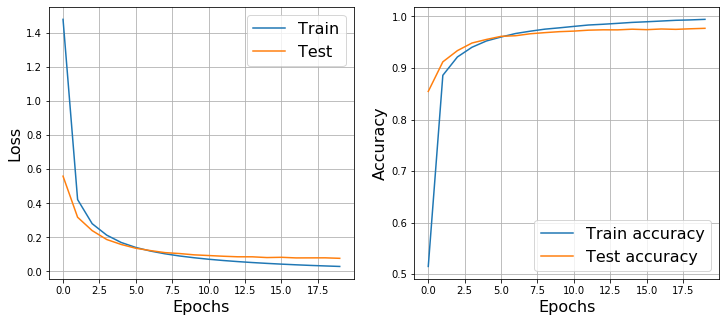

In [180]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

На трейне лучшая точность, но малость переобучились.

# Выбор функции активации

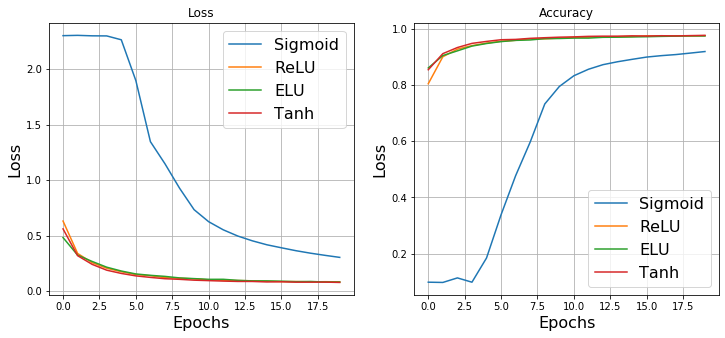

In [182]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

ELU и Tanh самые оптимальные функции потерь. Возьмем tanh

### Часть 3: Анализ ошибок

In [14]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

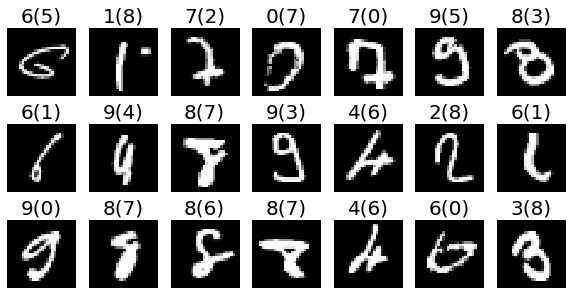

In [15]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

Аугментация применяется только для обучающей выборке

In [10]:
!pip install --upgrade scikit-image

Requirement already up-to-date: scikit-image in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages (0.18.1)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
from skimage.transform import rotate, warp, AffineTransform
from skimage.io import imread, imsave
from skimage import transform
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
from copy import deepcopy

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/geometry.cpython-37m-darwin.so, 2): Symbol not found: ____chkstk_darwin
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/../.dylibs/libomp.dylib
  Expected in: /usr/lib/libSystem.B.dylib
 in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/../.dylibs/libomp.dylib
It seems that scikit-image has not been built correctly.

Your install of scikit-image appears to be broken.
Try re-installing the package following the instructions at:
https://scikit-image.org/docs/stable/install.html 

In [17]:
from skimage.io import imread, imsave
from skimage import transform
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
from copy import deepcopy

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/geometry.cpython-37m-darwin.so, 2): Symbol not found: ____chkstk_darwin
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/../.dylibs/libomp.dylib
  Expected in: /usr/lib/libSystem.B.dylib
 in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skimage/_shared/../.dylibs/libomp.dylib
It seems that scikit-image has not been built correctly.

Your install of scikit-image appears to be broken.
Try re-installing the package following the instructions at:
https://scikit-image.org/docs/stable/install.html 

Начнем с вращений

In [62]:
def rotation_15(X):
    X_aug = np.zeros_like(X)
    for i, img in enumerate(X):
        X_aug[i] = rotate(img, 15.0)
    return X_aug

In [63]:
def rotation_345(X):
    X_aug = np.zeros_like(X)
    for i, img in enumerate(X):
        X_aug[i] = rotate(img, 345.0)
    return X_aug

In [64]:
def rotation(X):
    X_aug = np.zeros_like(X)
    angle = np.random.randint(-15, 15)
    for i, img in enumerate(X):
        X_aug[i] = rotate(img, angle)
    return X_aug

Сдвиги

In [65]:
def shear(X, shear_angle=0.1, p=1.0):
    X_aug = deepcopy(X)
    shear = shear_angle * np.random.randint(-4, 4)
    for i in np.random.choice(len(X_aug), int(len(X_aug) * p), replace=False):
        X_aug[i] = warp(X_aug[i], AffineTransform(shear=shear), mode='edge')
    return X_aug

Шум

In [12]:
def random_noise(X):
    X_aug = deepcopy(X)
    X_aug = random_noise(X_aug, var=0.1**2)
    X_aug = np.array(255*X_aug, dtype = 'uint8')

Проверим

In [13]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

Оригинал

(-0.5, 27.5, 27.5, -0.5)

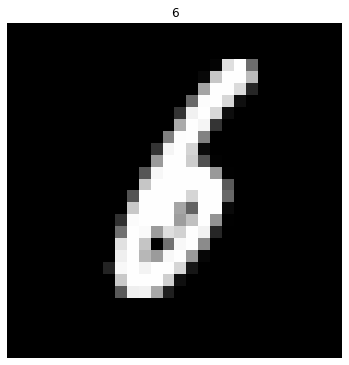

In [14]:
plt.figure(figsize=(6, 7))
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(y[0])
plt.axis('off')

Поворот на 15

In [15]:
plt.figure(figsize=(6, 7))
plt.imshow(rotation_15(X[0]).reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(y[0])
plt.axis('off')

NameError: name 'rotation_15' is not defined

<Figure size 432x504 with 0 Axes>

Поворот на 345

(-0.5, 27.5, 27.5, -0.5)

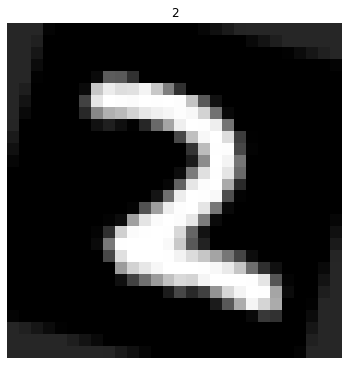

In [70]:
plt.figure(figsize=(6, 7))
plt.imshow(rotation_345(X[0]).reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(y[0])
plt.axis('off')

Случайный поворот

(-0.5, 27.5, 27.5, -0.5)

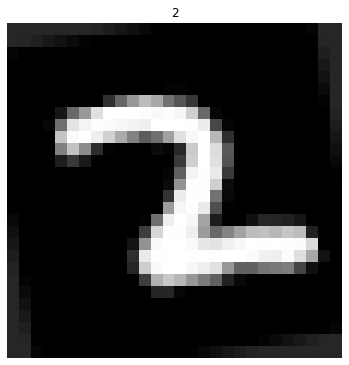

In [71]:
plt.figure(figsize=(6, 7))
plt.imshow(rotation(X[0]).reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(y[0])
plt.axis('off')

Случайный сдвиг

(-0.5, 27.5, 27.5, -0.5)

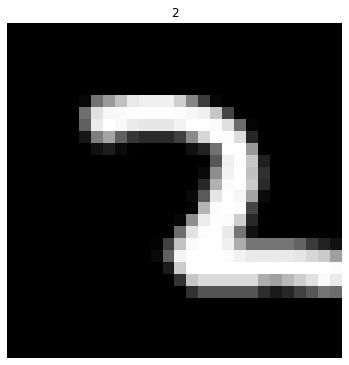

In [72]:
plt.figure(figsize=(6, 7))
plt.imshow(shear(X[0]).reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(y[0])
plt.axis('off')

Рандомный шум

In [16]:
plt.figure(figsize=(6, 7))
plt.imshow(random_noise(X[0]).reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(y[0])
plt.axis('off')

NameError: name 'deepcopy' is not defined

<Figure size 432x504 with 0 Axes>

Сначала добавим вращений в обучающую выборку

In [44]:
def train_rotation(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                X_rotated = deepcopy(X).reshape(-1, 1, 28, 28)
                X_rotated = np.array([rotation(X_rotated[i]) for i in range(X.shape[0])]).reshape(X.shape[0], -1)
                X_new = np.concatenate((X, X_rotated), axis=0)
                y_new = np.concatenate((y, y), axis=0)
                prediction = network.forward(X_new)
                loss_batch = loss.forward(prediction, y_new)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y_new).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.052/0.068	Accuracy: 0.986/0.980

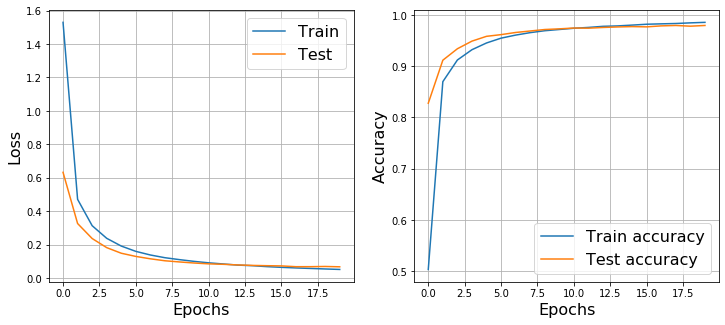

In [45]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train_rotation(network, 20, 0.01, plot=True, verbose=True)

Точность на тесте увеличилась!! На трейне - упала

Теперь добавим сдвиги

In [52]:
def train_shear(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                X_sheared = deepcopy(X).reshape(-1, 1, 28, 28)
                X_sheared = np.array([shear(X_sheared[i]) for i in range(X.shape[0])]).reshape(X.shape[0], -1)
                X_new = np.concatenate((X, X_sheared), axis=0)
                y_new = np.concatenate((y, y), axis=0)
                prediction = network.forward(X_new)
                loss_batch = loss.forward(prediction, y_new)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y_new).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.077/0.073	Accuracy: 0.978/0.978

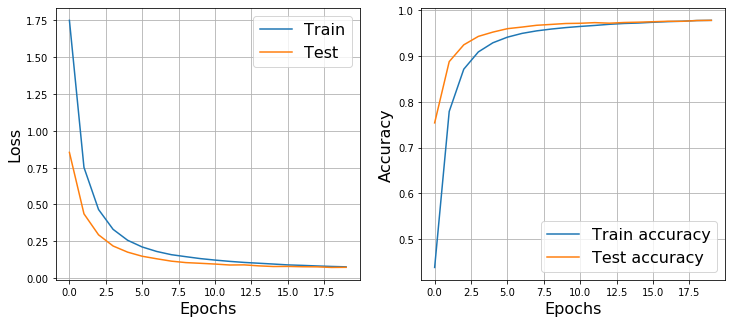

In [53]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_shear, ts_shear, tr_ac_shear, ts_ac_shear = train_shear(network, 20, 0.01, plot=True, verbose=True)

На тесте и трейне качество хуже, чем при вращениях

Добавим случайный шум

In [88]:
def train_noise(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                X_noise = deepcopy(X).reshape(-1, 1, 28, 28)
                X_noise = np.array([random_noise(X_noise[i]) for i in range(X.shape[0])]).reshape(X.shape[0], -1)
                X_new = np.concatenate((X, X_noise), axis=0)
                y_new = np.concatenate((y, y), axis=0)
                prediction = network.forward(X_new)
                loss_batch = loss.forward(prediction, y_new)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y_new).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.053/0.080	Accuracy: 0.986/0.976

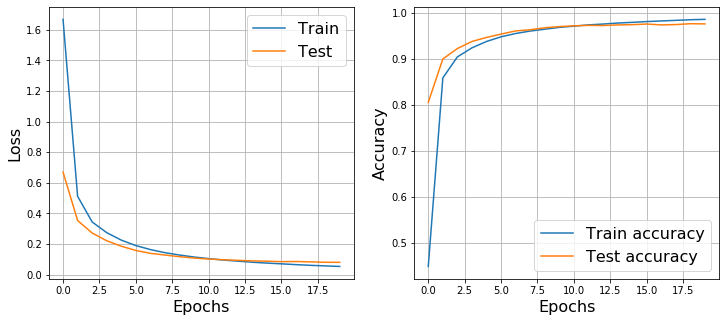

In [89]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_noise, ts_noise, tr_ac_noise, ts_ac_noise = train_noise(network, 20, 0.01, plot=True, verbose=True)

Нуу чуть-чуть получше,чем результат без аугментации.. а так качество на тесте не очень высокое.

Добавим всё, что накодили

In [90]:
def train_augmentation(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                X_rotated = deepcopy(X).reshape(-1, 1, 28, 28)
                X_rotated = np.array([rotation(X_rotated[i]) for i in range(X.shape[0])]).reshape(-1, 1, 28, 28)
                X_sheared = np.array([shear(X_rotated[i]) for i in range(X.shape[0])]).reshape(-1, 1, 28, 28)
                X_noise = np.array([random_noise(X_sheared[i]) for i in range(X.shape[0])]).reshape(X.shape[0], -1)
                X_new = np.concatenate((X, X_noise), axis=0)
                y_new = np.concatenate((y, y), axis=0)
                prediction = network.forward(X_new)
                loss_batch = loss.forward(prediction, y_new)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y_new).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 19... (Train/Test) NLL: 0.110/0.075	Accuracy: 0.968/0.977

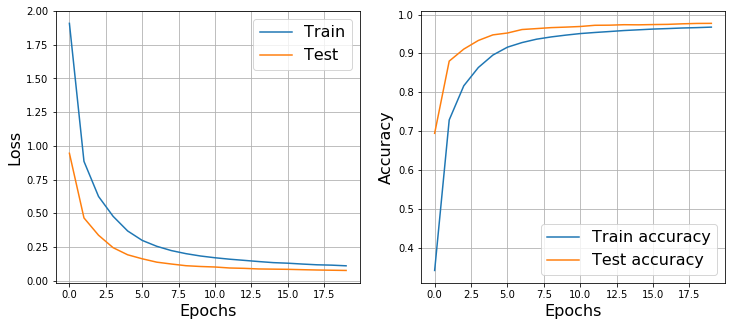

In [91]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_aug, ts_aug, tr_ac_aug, ts_ac_aug = train_augmentation(network, 20, 0.01, plot=True, verbose=True)

Не самый лучший результат как на трейне, так и на тесте.

Посмотрим на общую картину

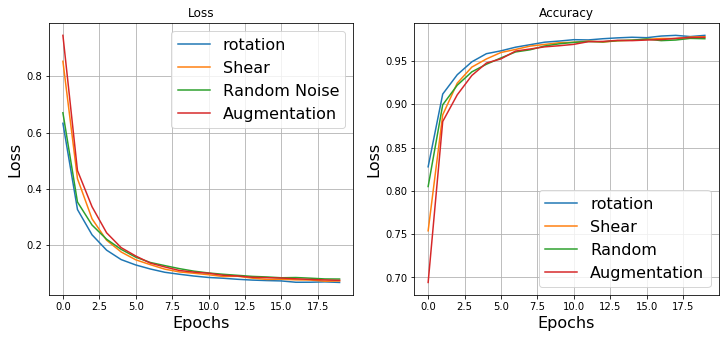

In [92]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_rot, label='rotation')
plt.plot(ts_shear, label='Shear')
plt.plot(ts_noise, label='Random Noise')
plt.plot(ts_aug, label='Augmentation')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_rot, label='rotation')
plt.plot(ts_ac_shear, label='Shear')
plt.plot(ts_ac_noise, label='Random')
plt.plot(ts_ac_aug, label='Augmentation')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()



### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

1. Из функций активации лучше всего себя показали ReLU, ELU и Tanh
2. Все способы аугментации показали себя хорошо, и чуть-чуть улучшили скор на тесте. 
3. Лучше всего совмещать все указанные способы, как я думаю, для борьбы с переобучением. По отдельности, хуже, относительно других способов, себя показал способ с добавлением случайного шума

## Использование torchvision.transforms

In [345]:
!pip install --upgrade torchvision

     |████████████████████████████████| 1.0 MB 845 kB/s eta 0:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [93]:
from torch.utils.data import ConcatDataset
import torch
from PIL import Image
from torch import Tensor

In [94]:
def train_universal(network, epochs, learning_rate, train_loader, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [95]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=False, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Только вращения

In [96]:
transform_rot = transforms.Compose([
                       transforms.RandomRotation((-15, 15)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset_rot = MNIST('.', train=True, download=True, transform=transform_rot)

final_dataset = ConcatDataset((train_dataset, train_dataset_rot))
train_loader_rot = DataLoader(final_dataset, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.031/0.059	Accuracy: 0.991/0.981

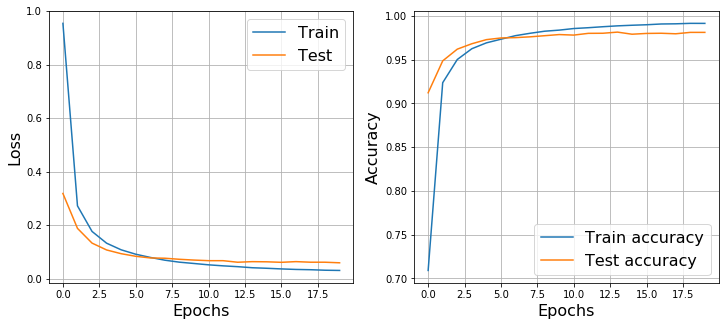

In [97]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train_universal(network, 20, 0.01, train_loader=train_loader_rot, plot=True, verbose=True)

Результат лучше, чем если бы аугментация делалась внутри батча.

Афинные преобразования

In [98]:
transform_shear = transforms.Compose([
                       transforms.RandomAffine((-0.4, 0.4)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                        ])
train_dataset_shear = MNIST('.', train=True, download=True, transform=transform_shear)

final_dataset = ConcatDataset((train_dataset, train_dataset_shear))
train_loader_shear = DataLoader(final_dataset, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.006/0.074	Accuracy: 1.000/0.980

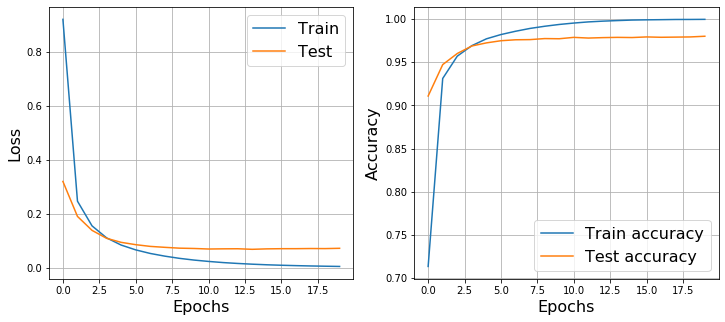

In [99]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_shear, ts_shear, tr_ac_shear, ts_ac_shear = train_universal(network, 20, 0.01, train_loader=train_loader_shear, plot=True, verbose=True)

Переобучились!! Но на тесте качество нормальное

Гауссовский шум

In [100]:
transform_noise = transforms.Compose([
                       transforms.GaussianBlur(5),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                        ])
train_dataset_noise = MNIST('.', train=True, download=True, transform=transform_noise)

final_dataset = ConcatDataset((train_dataset, train_dataset_noise))
train_loader_noise = DataLoader(final_dataset, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.022/0.073	Accuracy: 0.995/0.978

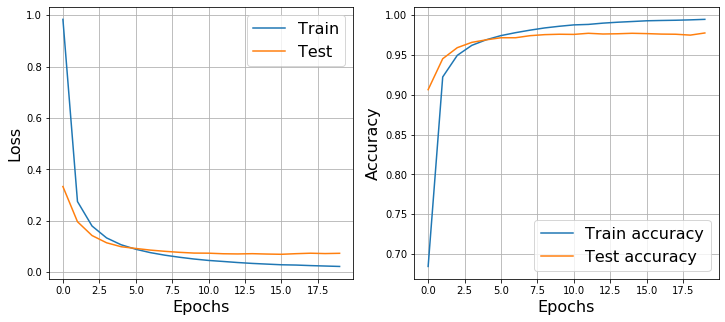

In [101]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_noise, ts_noise, tr_ac_noise, ts_ac_noise = train_universal(network, 20, 0.01, train_loader=train_loader_noise, plot=True, verbose=True)

Добавление гауссовкого шума показывает себя не лучшим образом..

Все перечисленные способы вместе

In [103]:
transform_aug = transforms.Compose([
                       transforms.RandomRotation((-15, 15)),
                       transforms.RandomAffine((-0.4, 0.4)),
                       transforms.GaussianBlur(5),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                        ])
train_dataset_aug = MNIST('.', train=True, download=True, transform=transform_aug)

final_dataset = ConcatDataset((train_dataset, train_dataset_aug))
train_loader_aug = DataLoader(final_dataset, batch_size=32, shuffle=True)

Epoch 19... (Train/Test) NLL: 0.043/0.063	Accuracy: 0.987/0.980

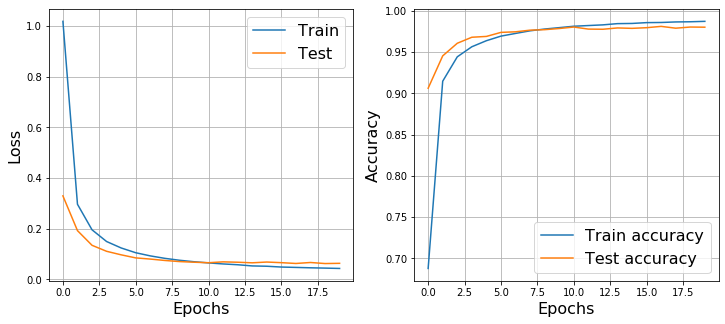

In [104]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_aug, ts_aug, tr_ac_aug, ts_ac_aug = train_universal(network, 20, 0.01, train_loader=train_loader_aug, plot=True, verbose=True)

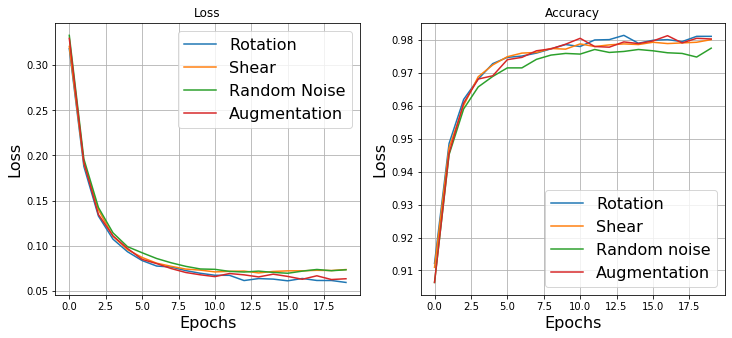

In [106]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_rot, label='Rotation')
plt.plot(ts_shear, label='Shear')
plt.plot(ts_noise, label='Random Noise')
plt.plot(ts_aug, label='Augmentation')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_rot, label='Rotation')
plt.plot(ts_ac_shear, label='Shear')
plt.plot(ts_ac_noise, label='Random noise')
plt.plot(ts_ac_aug, label='Augmentation')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

## Выводы

1. Сначала пробовал делать аугментацию внутри батча. Максимальный accuracy = 0.980, что не очень хорошо..
2. Если делать отдельно датасет с изображениями после аугментации, то результат лучше.
3. Если смотреть отдельно, то добавление случайного шума показала себя хуже, чем остальные методы